In [1]:
# Libraries for getting the data
import numpy as np
import pandas as pd
# from docx import Document
from src.modules import * #contains functions used in common with processing election and IRS data
import os

In [2]:
# Filepath to our formatted datasets (see 'merge_State_IRS_data.py' for how these were generated)
datasets_filepath = 'data/logarithm_of_joined_data/' 

datasets= [file for file in os.listdir(datasets_filepath) if os.path.isfile(os.path.join(datasets_filepath, file))]

### NOTE: Due to the nameing conventions used in merge_State_IRS_data.py, every even-indexed dataframe ([0),[2],[4],[6]..(etc. etc.) will be the election data merged with the IRS data from that year
### Every odd-indexed dataframe will contain the election data for that year merged with the IRS data from that year LESS the values from the previous year.

# Name an empty dataframe for the .csvs containing only IRS data from the year of the election
house_IRS_f = pd.DataFrame()

# Iterate through the list of csv files, merging the appropriate ones
for i in range(0, len(datasets), 2): #selects ever-other dataframe, starting with the first.
    csv_file = datasets[i]
    data = pd.read_csv(os.path.join(datasets_filepath, csv_file))
    house_IRS_f = pd.concat([house_IRS_f, data], axis=0, ignore_index=True)
    
# Drop any null columns (The number of columns in the IRS data increases year-to-year, bureaucratically)
house_IRS_f = house_IRS_f.dropna(axis=1)

In [3]:
# Name an empty dataframe for .csvs containing IRS data LESS the previous year's data
house_IRS_d = pd.DataFrame()

# Iterate through the list of csv files, merging the appropriate ones
for i in range(1, len(datasets), 2): #selects ever-other dataframe, starting with the first.
    csv_file = datasets[i]
    data = pd.read_csv(os.path.join(datasets_filepath, csv_file))
    house_IRS_d = pd.concat([house_IRS_d, data], axis=0, ignore_index=True)
    
# Drop any null columns (The number of columns in the IRS data increases year-to-year, bureaucratically)
house_IRS_d = house_IRS_d.dropna(axis=1)

In [4]:
# Compose the columns
# 'Dem_Voteshare' is the percent of total votes received by candidates from the Democratic party
# 'Dem_tot' is the total votes received by Dem. incumbants and challengers
# 'Rep_tot' is the total votes received by Rep. incumbants and challengers
house_IRS_f['Dem_Voteshare'] = (house_IRS_f['D0'] + house_IRS_f['D1'])/ (house_IRS_f['D0'] + house_IRS_f['D1'] + house_IRS_f['R0'] + house_IRS_f['R1'] + house_IRS_f['OTHER0'])
house_IRS_f['Dem_tot'] = (house_IRS_f['D0'] + house_IRS_f['D1'])
house_IRS_f['Rep_tot'] = (house_IRS_f['R0'] + house_IRS_f['R1'])
# col_to_drop = ['D0', 'D1', 'OTHER0', 'R0', 'R1']

# Compose the columns
house_IRS_d['Dem_Voteshare'] = (house_IRS_d['D0'] + house_IRS_d['D1'])/ (house_IRS_d['D0'] + house_IRS_d['D1'] + house_IRS_d['R0'] + house_IRS_d['R1'] + house_IRS_d['OTHER0'])
house_IRS_d['Dem_tot'] = (house_IRS_d['D0'] + house_IRS_d['D1']) 
house_IRS_d['Rep_tot'] = (house_IRS_d['R0'] + house_IRS_d['R1'])
# col_to_drop = ['D0', 'D1', 'OTHER0', 'R0', 'R1']

In [6]:

house_IRS_f2 = house_IRS_f.drop(['D0', 'D1', 'OTHER0', 'R0', 'R1'],axis=1)

house_IRS_d2 = house_IRS_d.drop(['D0', 'D1', 'OTHER0', 'R0', 'R1'],axis=1)

In [7]:
# Load Libraries for visualizing the dfs

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest

In [8]:
# Scale the data
# Opting for MinMax here, but run with StandardScaler() as well, see if it produces different results
scaler_MM = MinMaxScaler()
f2_data_scaled_MM = pd.DataFrame(scaler_MM.fit_transform(house_IRS_f2), columns=house_IRS_f2.columns)


In [ ]:
# # Detect outliers using Isolation Forest 
# ### This was recommended, but has not been deployed yet as I do not fully understand it
# isolation_forest = IsolationForest(contamination=0.05, random_state=12)
# is_inlier = isolation_forest.fit_predict(f2_data_scaled_MM)


In [ ]:
# # Create histograms for each feature
# for c in house_IRS_f2.columns:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(f2_data_scaled_MM[c], bins=30, kde=True)
#     plt.title(f'Histogram for {c}')
#     plt.show()

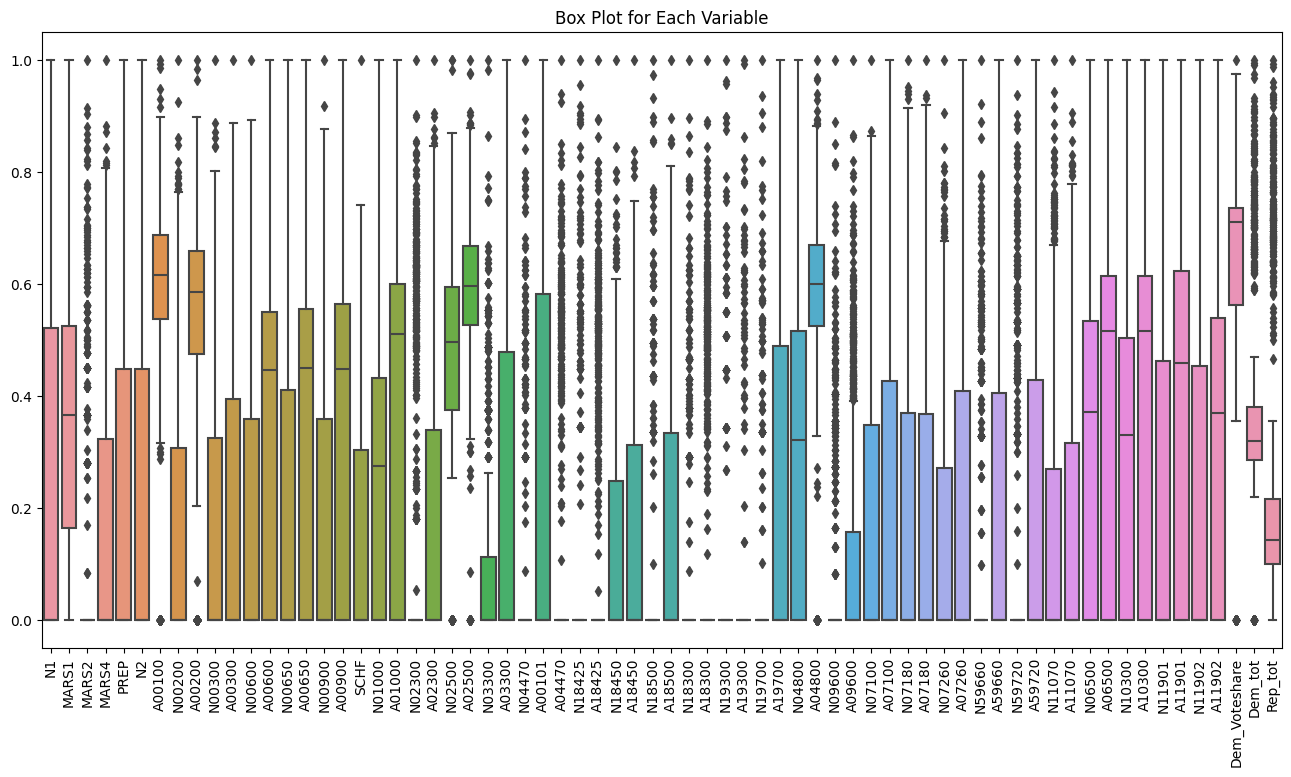

In [9]:
# Create box plots for each feature
plt.figure(figsize=(16, 8))
sns.boxplot(data=f2_data_scaled_MM)
plt.title('Box Plot for Each Variable')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Scale the data
# Opting for MinMax here, but run with StandardScaler() as well, see if it produces different results
scaler_ss = StandardScaler()
f2_data_scaled_S = pd.DataFrame(scaler_ss.fit_transform(house_IRS_f2), columns=house_IRS_f2.columns)


In [ ]:
# # Create histograms for each feature
# for c in house_IRS_f2.columns:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(f2_data_scaled_S[c], bins=30, kde=True)
#     plt.title(f'Histogram for {c}')
#     plt.show()

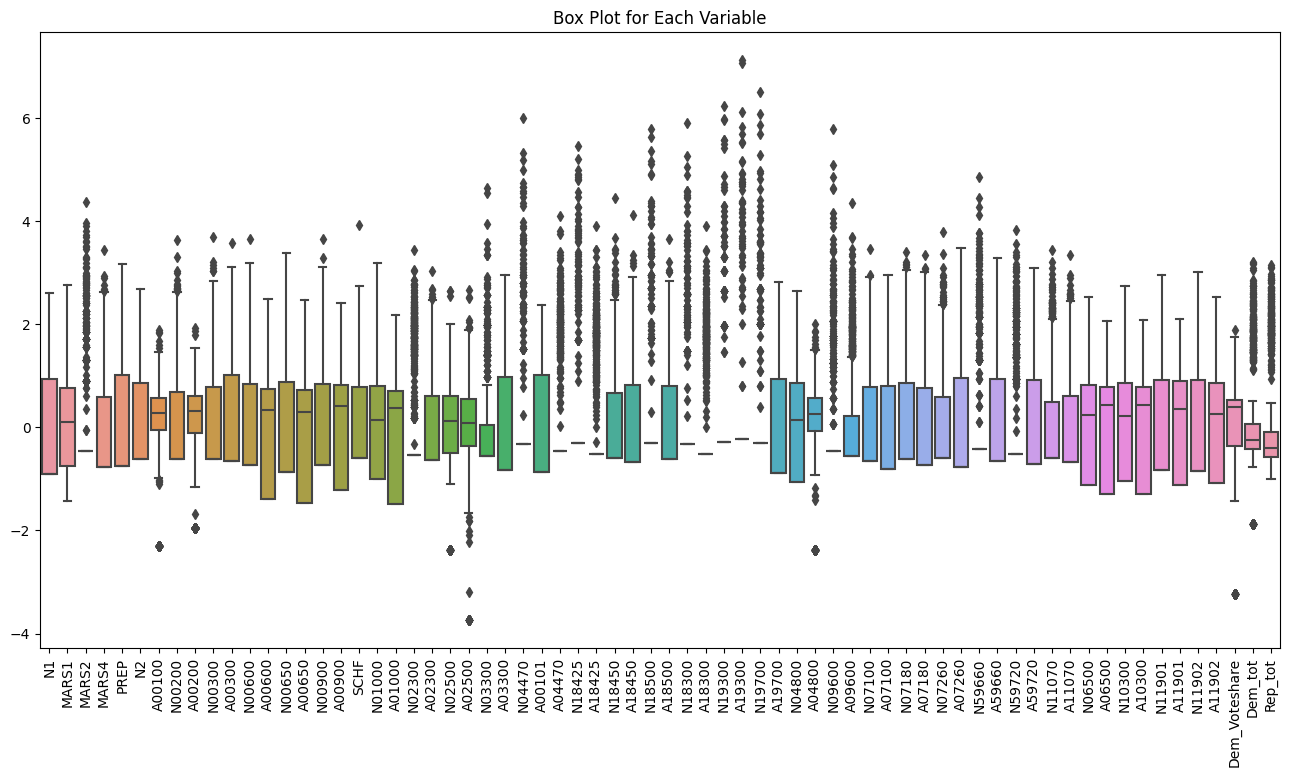

In [11]:
# Create box plots for each feature
plt.figure(figsize=(16, 8))
sns.boxplot(data=f2_data_scaled_S)
plt.title('Box Plot for Each Variable')
plt.xticks(rotation=90)
plt.show()

In [ ]:
### Sooooo that looks like a lot of outliers

In [12]:
### Let's at least try a basic Gridsearch and random forest modeling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA # There are a LOT of features, so using PCA to reduce them seems like a good idea
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #using MSE at first, remember to try other error metrics

In [13]:
# Assign X and y
X = house_IRS_f2.drop(['Dem_Voteshare', 'Dem_tot', 'Rep_tot'],axis=1)
### when re-running, try with a y of ONLY "Dem_Voteshare"
y = house_IRS_f2[['Dem_tot','Rep_tot']]
y_min = house_IRS_f2['Dem_Voteshare']

In [14]:
# Scale data
X_scaled = scaler_ss.fit_transform(X)


# Perform PCA to reduce features
num_components = 15  # Consider adjusting this value if results are unsatisfactory
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)


# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=12)

# Assign model
model = RandomForestRegressor()

# first pass at guessing hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# build grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error on Test Set: 15.395797145938262


In [ ]:
# # Step 1: Scale the data with StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Step 2: Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Step 3: Choose a model (Random Forest Regressor in this example)
# model = RandomForestRegressor()

# # Step 4: Define hyperparameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Step 5: Create GridSearchCV object
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# # Step 6: Fit the model with GridSearchCV
# grid_search.fit(X_train, y_train)

# # Step 7: Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best Hyperparameters: {best_params}")

# # Step 8: Make predictions on the test set using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Step 9: Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error on Test Set: {mse}")

In [15]:
### Check with min-max Scaling as well

# Scale data with Min-Max and re-run
X_scaled_MM = scaler_MM.fit_transform(X)

# Perform PCA to reduce features
num_components = 15  # Consider adjusting this value if results are unsatisfactory
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled_MM)


# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=12)

# Assign model
model = RandomForestRegressor()

# first pass at guessing hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# build grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error on Test Set: 15.154405501605495


In [ ]:
# re-run with 'y_min' (Only 'Dem_Voteshare')

In [ ]:
# Scale data
X_scaled = scaler_ss.fit_transform(X)


# Perform PCA to reduce features
num_components = 15  # Consider adjusting this value if results are unsatisfactory
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)


# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_min, test_size=0.2, random_state=12)

# Assign model
model = RandomForestRegressor()

# first pass at guessing hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# build grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")

In [ ]:
### Check with min-max Scaling as well

# Scale data with Min-Max and re-run
X_scaled_MM = scaler_MM.fit_transform(X)

# Perform PCA to reduce features
num_components = 15  # Consider adjusting this value if results are unsatisfactory
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled_MM)


# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_min, test_size=0.2, random_state=12)

# Assign model
model = RandomForestRegressor()

# first pass at guessing hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# build grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")

In [ ]:

### Let's build a more robust gridsearch

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

In [ ]:
# Assign X and y
X = house_IRS_f2.drop(['Dem_Voteshare', 'Dem_tot', 'Rep_tot'],axis=1)
### when re-running, try with a y of ONLY "Dem_Voteshare"
y = house_IRS_f2[['Dem_tot','Rep_tot']]
y_min = house_IRS_f2['Dem_Voteshare']

### Reminder - if StandardScaler() is used, consider re-running with Min-Max
X_scaled = scaler_ss.fit_transform(X)

# PCA to reduce the number of features
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=12)

# List Models and their respective hyperparameter grids 
### THESE will likely require more tuning
models = {
    'XGBoost': (XGBRegressor(), {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [25, 50, 75, 150], 'max_depth': [3, 5, 7]}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
}

# Perform GridSearchCV for each model
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Access best hyperparameters and model for each model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Best hyperparameters for {model_name}: {best_params}")
    print(f"Best model for {model_name}: {best_model}")
    print(f"Mean Squared Error on Test Set: {mse}\n")

In [ ]:

### Re-run with Min-max
X_scaled = scaler_ss.fit_transform(X)

# PCA to reduce the number of features
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=12)

# List Models and their respective hyperparameter grids 
### THESE will likely require more tuning
models = {
    'XGBoost': (XGBRegressor(), {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [25, 50, 75, 150], 'max_depth': [3, 5, 7]}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
}

# Perform GridSearchCV for each model
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Access best hyperparameters and model for each model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Best hyperparameters for {model_name}: {best_params}")
    print(f"Best model for {model_name}: {best_model}")
    print(f"Mean Squared Error on Test Set: {mse}\n")

In [ ]:

### Reminder - if StandardScaler() is used, consider re-running with Min-Max
X_scaled = scaler_ss.fit_transform(X)

# PCA to reduce the number of features
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_min, test_size=0.2, random_state=12)

# List Models and their respective hyperparameter grids 
### THESE will likely require more tuning
models = {
    'XGBoost': (XGBRegressor(), {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [25, 50, 75, 150], 'max_depth': [3, 5, 7]}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1.0, 10.0, 25]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
}

# Perform GridSearchCV for each model
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Access best hyperparameters and model for each model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Best hyperparameters for {model_name}: {best_params}")
    print(f"Best model for {model_name}: {best_model}")
    print(f"Mean Squared Error on Test Set: {mse}\n")